In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1: inspect & initial-clean Schiphol CSV

In [104]:
import pandas as pd
import numpy as np

INPUT_CSV = "/content/drive/MyDrive/FIT5126 Research/schiphol_flights_20250701_20250731.csv"
LOCAL_TZ = "Europe/Amsterdam"

# ---- 1) Load raw CSV and keep a backup copy ----
df_raw = pd.read_csv(INPUT_CSV)
print("Loaded file:", INPUT_CSV)
print("Initial columns:", df_raw.columns.tolist())
print("Initial row count:", len(df_raw))

# Work on a copy so never overwrite the raw frame
df = df_raw.copy()

# ---- 2) Quick diagnostics: null counts per column ----
print("\nNull counts per column:")
print(df.isna().sum())

# Identify columns that are entirely empty (but keep 'Stand' even if empty)
cols_all_nan = [c for c in df.columns if df[c].isna().all() and c != 'Stand']
print("\nColumns entirely empty (would be dropped except 'Stand'):", cols_all_nan)

# If there are fully-empty columns (except Stand) then drop them now (safe)
if cols_all_nan:
    df = df.drop(columns=cols_all_nan)
    print("Dropped columns:", cols_all_nan)
else:
    print("No fully-empty columns to drop (except Stand).")

# ---- 3) Scheduled Time parsing: two-step, conservative approach ----
# Try to parse as UTC-aware first (handles ISO strings with timezone offsets).
df['Scheduled_parsed_utc'] = pd.to_datetime(df['Scheduled Time'], errors='coerce', utc=True)

num_np_utc = df['Scheduled_parsed_utc'].isna().sum()
print(f"\nScheduled_parsed_utc: {num_np_utc} rows could not be parsed as utc-aware (NaT) out of {len(df)}")

# If a lot failed, attempt alternative parsing (assume naive datetimes are local)
THRESHOLD_FAIL_RATIO = 0.15  # if >15% failed, try alternate parse
fail_ratio = num_np_utc / max(1, len(df))
if fail_ratio > THRESHOLD_FAIL_RATIO:
    print("More than {:.0%} of Scheduled Time failed to parse as utc-aware; trying alternative parse.".format(THRESHOLD_FAIL_RATIO))
    # Parse without utc (generate naive datetimes), then localize to Europe/Amsterdam
    tmp = pd.to_datetime(df['Scheduled Time'], errors='coerce', utc=False)
    # If parsed as naive, localize (treat as local time)
    # Create a local-parsed column; keep both for inspection
    df['Scheduled_parsed_local'] = tmp.dt.tz_localize(LOCAL_TZ, ambiguous='NaT', nonexistent='NaT')
    num_local_fail = df['Scheduled_parsed_local'].isna().sum()
    print(f"Scheduled_parsed_local: {num_local_fail} rows failed using local-localize approach.")
else:
    # For rows parsed in UTC, also create a local-converted column for convenience
    df['Scheduled_parsed_local'] = df['Scheduled_parsed_utc'].dt.tz_convert(LOCAL_TZ)
    print("Converted Scheduled_parsed_utc to local timezone column Scheduled_parsed_local.")

# Show parsed range and NaT counts for both parsed columns
print("\nParsed time summary:")
for col in ['Scheduled_parsed_utc', 'Scheduled_parsed_local']:
    if col in df.columns:
        non_null = df[col].dropna()
        if len(non_null) > 0:
            print(f" {col}: min = {non_null.min()}, max = {non_null.max()}, count_nonnull = {len(non_null)}")
        else:
            print(f" {col}: all NaT")

# ---- 4) Do NOT drop rows yet; report how many rows have no valid scheduled time ----
rows_no_time = df[df['Scheduled_parsed_local'].isna()].shape[0] if 'Scheduled_parsed_local' in df.columns else df[df['Scheduled_parsed_utc'].isna()].shape[0]
print(f"\nRows without any parsed Scheduled Time (to review, not auto-dropped): {rows_no_time}")

# ---- 5) Status column: show unique raw values and counts (for normalization next) ----
if 'Status' in df.columns:
    print("\nStatus unique values and counts (raw):")
    print(df['Status'].fillna('<<NA>>').value_counts().head(200))
else:
    print("\nNo 'Status' column found in the data.")

# ---- 6) Quick Gate column diagnostics (unique count + sample) ----
if 'Gate' in df.columns:
    n_gate_nonnull = df['Gate'].notna().sum()
    n_gate_unique = df['Gate'].dropna().nunique()
    print(f"\nGate: non-null rows = {n_gate_nonnull}, unique gate values = {n_gate_unique}")
    print("Gate sample (first 30 unique):", list(df['Gate'].dropna().unique())[:30])
else:
    print("\nNo 'Gate' column in data.")

# ---- 7) Final: show shape and a small preview (do NOT overwrite) ----
print("\nDataFrame shape after step1 (no row drops):", df.shape)
preview_cols = [c for c in ['Flight Number', 'Airline', 'Status', 'Scheduled Time', 'Scheduled_parsed_local', 'Gate', 'Stand', 'Terminal'] if c in df.columns]
print("\nPreview (first 10 rows):")
print(df[preview_cols].head(10).to_string(index=False))


Loaded file: /content/drive/MyDrive/FIT5126 Research/schiphol_flights_20250701_20250731.csv
Initial columns: ['Flight Number', 'Airline', 'Status', 'Scheduled Time', 'Gate', 'Stand', 'Terminal']
Initial row count: 148053

Null counts per column:
Flight Number          0
Airline           148053
Status                 0
Scheduled Time         0
Gate               75894
Stand             148053
Terminal            5009
dtype: int64

Columns entirely empty (would be dropped except 'Stand'): ['Airline']
Dropped columns: ['Airline']

Scheduled_parsed_utc: 0 rows could not be parsed as utc-aware (NaT) out of 148053
Converted Scheduled_parsed_utc to local timezone column Scheduled_parsed_local.

Parsed time summary:
 Scheduled_parsed_utc: min = 2025-06-30 22:00:00+00:00, max = 2025-07-31 21:50:00+00:00, count_nonnull = 148053
 Scheduled_parsed_local: min = 2025-07-01 00:00:00+02:00, max = 2025-07-31 23:50:00+02:00, count_nonnull = 148053

Rows without any parsed Scheduled Time (to review, not

# Step 2: clean Status column

In [105]:
# Simplified Status normalization:
# - All arrival-like statuses -> 'ARR'
# - All departure-like statuses -> 'DEP'
# - Departure statuses containing 'DEL' -> 'DEP_DELAYED' (takes precedence)
# - Everything else -> 'OTHER'
import pandas as pd

def normalize_status_simplified(raw_status):
    if pd.isna(raw_status):
        return 'OTHER'
    s = str(raw_status).strip().upper()
    # Handle departure-like strings first (so GTD, DEP, etc. are detected)
    if ('DEP' in s) or ('GTD' in s):
        # If delay marker present, mark as delayed departure
        if 'DEL' in s:
            return 'DEP_DELAYED'
        else:
            return 'DEP'
    # Arrival-like strings
    if ('ARR' in s) or ('LND' in s):
        return 'ARR'
    # Fallback
    return 'OTHER'

# Apply the simplified mapping and create a new column
df['Status_simplified'] = df['Status'].apply(normalize_status_simplified)

# Diagnostics: show mapping preview and counts
print("Status mapping preview (sample):")
print(df[['Status', 'Status_simplified']].drop_duplicates().to_string(index=False))

print("\nStatus_simplified value counts:")
print(df['Status_simplified'].value_counts(dropna=False))


Status mapping preview (sample):
 Status Status_simplified
ARR,EXP               ARR
    ARR               ARR
LND,EXP               ARR
    DEP               DEP
    LND               ARR
DEP,DEL       DEP_DELAYED
    SCH             OTHER
    CNX             OTHER
SCH,GCH             OTHER
    GTO             OTHER
SCH,EXP             OTHER
    FIB             OTHER
FIB,EXP             OTHER
GTD,DEL       DEP_DELAYED
    WIL             OTHER

Status_simplified value counts:
Status_simplified
ARR            72712
DEP            54121
DEP_DELAYED    17958
OTHER           3262
Name: count, dtype: int64


In [106]:
df.head()

,Flight Number,Status,Scheduled Time,Gate,Stand,Terminal,Scheduled_parsed_utc,Scheduled_parsed_local,Status_simplified
0,HV5886,"ARR,EXP",2025-07-01T00:00:00.000+02:00,NaN,NaN,1.0,2025-06-30 22:00:00+00:00,2025-07-01 00:00:00+02:00,ARR
1,HV6874,"ARR,EXP",2025-07-01T00:05:00.000+02:00,NaN,NaN,4.0,2025-06-30 22:05:00+00:00,2025-07-01 00:05:00+02:00,ARR
2,KL2558,"ARR,EXP",2025-07-01T00:05:00.000+02:00,NaN,NaN,4.0,2025-06-30 22:05:00+00:00,2025-07-01 00:05:00+02:00,ARR
3,HV6914,ARR,2025-07-01T00:10:00.000+02:00,NaN,NaN,1.0,2025-06-30 22:10:00+00:00,2025-07-01 00:10:00+02:00,ARR
4,KL2612,ARR,2025-07-01T00:10:00.000+02:00,NaN,NaN,1.0,2025-06-30 22:10:00+00:00,2025-07-01 00:10:00+02:00,ARR


# Step 3: view the range and frequency of all existing boarding gates

In [107]:
from itertools import groupby
import re

# --- Get the only boarding gate (remove null values) ---
unique_gates = sorted(df['Gate'].dropna().unique())

# --- Regular expression: extract letter prefix and number part ---
gate_pattern = re.compile(r"^([A-Z]+)(\d+)$", re.IGNORECASE)
parsed_gates = []

for g in unique_gates:
    g_str = str(g).strip()  # Convert to a string and remove spaces
    match = gate_pattern.match(g_str)
    if match:
        prefix, num = match.groups()
        parsed_gates.append((prefix.upper(), int(num)))

# --- Group by alphabetical prefix ---
ranges_by_prefix = {}
for prefix, group in groupby(sorted(parsed_gates), key=lambda x: x[0]):
    nums = sorted(num for _, num in group)

    # Find consecutive number ranges
    seqs = []
    start = prev = nums[0]
    for n in nums[1:]:
        if n == prev + 1:
            prev = n
        else:
            seqs.append((start, prev))
            start = prev = n
    seqs.append((start, prev))

    ranges_by_prefix[prefix] = seqs

# --- Print Gate range ---
for prefix, seqs in ranges_by_prefix.items():
    formatted = []
    for start, end in seqs:
        if start == end:
            formatted.append(f"{prefix}{start}")
        else:
            formatted.append(f"{prefix}{start}-{prefix}{end}")
    print(f"{prefix}: {', '.join(formatted)}")


B: B1-B8, B15-B18, B20, B22-B24, B26-B28, B30-B32, B34-B36
C: C5-C16, C18, C21-C24
D: D2-D7, D10, D12, D14, D16, D18, D22-D29, D31, D41-D44, D47-D49, D51-D57, D60, D62-D63, D66, D68, D71, D73-D74, D77-D79, D81-D87
E: E2-E9, E17-E18, E20-E22, E24
F: F3-F9
G: G1-G9
H: H1-H7
M: M1-M7


In [108]:
# --- Calculate occurrences per gate ---
gate_counts = df['Gate'].value_counts().reset_index()
gate_counts.columns = ['Gate', 'Occurrences']

# --- Save or inspect result ---
print(gate_counts.sort_values(['Occurrences']))
gate_counts.to_csv("gate_classification.csv", index=False)


    Gate  Occurrences
137   D3           32
136  D42           41
135   H7           45
134   M7           58
133  D44           63
..   ...          ...
4     B7         1468
3    B22         1504
2     B6         1522
1     B3         2112
0     D6         6691

[138 rows x 2 columns]


# Step 4: Insert value in the Stand column for departure flights
Based on known Bridge Stands:

- B1–B36

- C1–C18

- D1–D31, D41–D57

- E12–E24

- F1–F9

- G1–G9

- H1–H7

- M1–M7

Only when Gate is not empty will the stand matching be performed. (because Gate represents the boarding gate number and only appears on the departure flight)

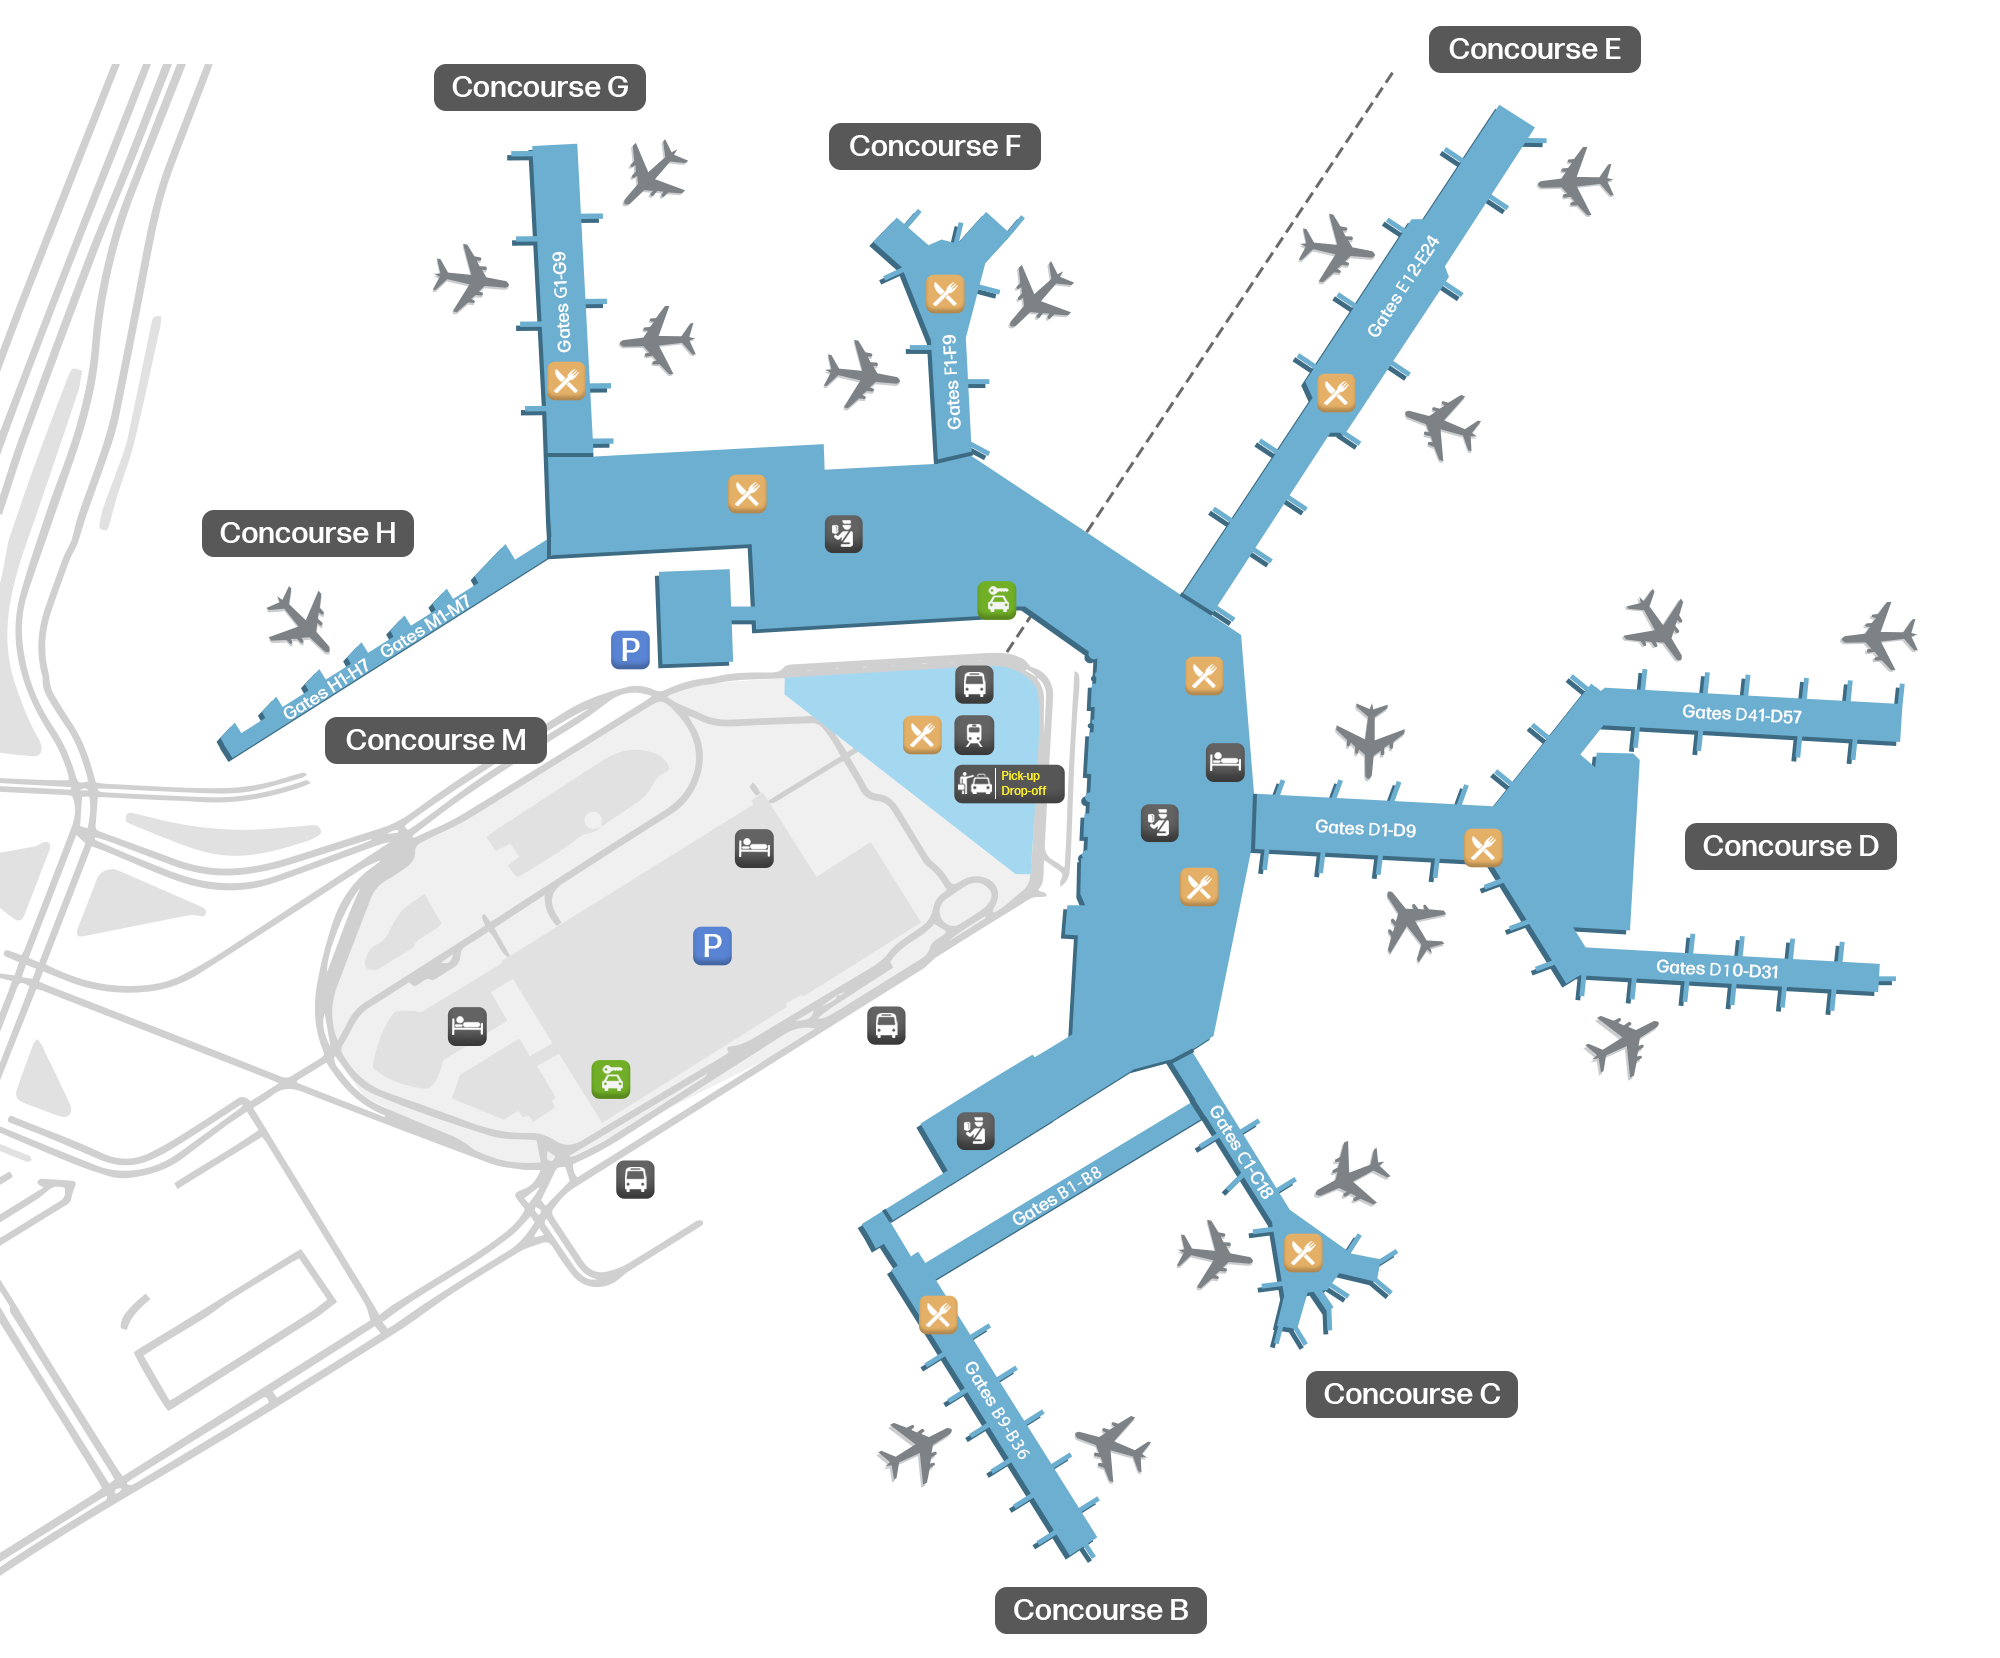

In [109]:
import pandas as pd

# --- 1) Define known bridge gates ---
bridge_gates = {
    *{f'B{i}' for i in range(1, 37)},   # B1-B36
    *{f'C{i}' for i in range(1, 19)},   # C1-C18
    *{f'D{i}' for i in range(1, 32)},   # D1-D31
    *{f'D{i}' for i in range(41, 58)},  # D41-D57
    *{f'E{i}' for i in range(12, 25)},  # E12-E24
    *{f'F{i}' for i in range(1, 10)},   # F1-F9
    *{f'G{i}' for i in range(1, 10)},   # G1-G9
    *{f'H{i}' for i in range(1, 8)},    # H1-H7
    *{f'M{i}' for i in range(1, 8)}     # M1-M7
}

# Normalize bridge_gates to uppercase (just in case)
bridge_gates = {g.upper() for g in bridge_gates}

# --- 2) Build deterministic mapping for unknown gates -> remote stands (R001, R002, ...) ---
# Collect all unique, non-null gate strings (normalized)
unique_gates = (
    df['Gate']
    .dropna()
    .astype(str)
    .str.upper()
    .str.strip()
    .unique()
)

# Unknown gates = those present in data but NOT in known bridge set
unknown_gates = sorted([g for g in unique_gates if g not in bridge_gates])

# Create a deterministic mapping: Gate -> virtual remote stand id (R001, R002, ...)
remote_stand_map = {g: f"R{idx+1:03d}" for idx, g in enumerate(unknown_gates)}

# --- 3) Map Gate -> Stand (only for departures: Gate non-empty) ---
def map_gate_to_stand(g):
    if pd.isna(g) or str(g).strip() == "":
        return None
    gs = str(g).upper().strip()
    if gs in bridge_gates:
        return gs
    return remote_stand_map.get(gs)  # deterministic R### (or None if unexpected)

df['Stand'] = df['Gate'].apply(map_gate_to_stand)

# --- 4) Assign Stand_Type ---
def map_stand_type(s):
    if pd.isna(s):
        return None
    return 'Bridge' if s in bridge_gates else 'Remote'

df['Stand_Type'] = df['Stand'].apply(map_stand_type)

# --- 5) Summaries: flight counts and unique stand counts ---
flight_bridge_count = int(df['Stand_Type'].eq('Bridge').sum())
flight_remote_count = int(df['Stand_Type'].eq('Remote').sum())

unique_bridge_stands = sorted(df.loc[df['Stand_Type']=='Bridge', 'Stand'].dropna().unique())
unique_remote_stands = sorted(df.loc[df['Stand_Type']=='Remote', 'Stand'].dropna().unique())

n_bridge_stands = len(unique_bridge_stands)
n_remote_stands = len(unique_remote_stands)

print("=== Summary ===")
print(f"Flights assigned to Bridge stands : {flight_bridge_count}")
print(f"Flights assigned to Remote stands : {flight_remote_count}")
print(f"Unique Bridge stands (count)      : {n_bridge_stands}")
print(f"Unique Remote stands (count)      : {n_remote_stands}")

# --- 6) Flights per stand (useful to spot very-low-frequency stands) ---
stand_counts = (
    df['Stand']
    .value_counts(dropna=True)
    .rename_axis('Stand')
    .reset_index(name='Flights')
)

# add type column
stand_counts['Type'] = stand_counts['Stand'].apply(lambda s: 'Bridge' if s in bridge_gates else 'Remote')

# Sort by Flights desc (most busy stands first)
stand_counts = stand_counts.sort_values(['Type','Flights'], ascending=[True, False]).reset_index(drop=True)

# show top and a few samples
print("\nTop 20 busiest stands:")
print(stand_counts.head(20).to_string(index=False))

print("\nA few low-frequency stands (to inspect candidates for remotes):")
print(stand_counts.tail(20).to_string(index=False))

# --- 7) Save outputs for manual inspection if desired ---
stand_counts.to_csv("stand_counts_by_type.csv", index=False)
df.to_csv("stand_assignment.csv", index=False)

print("\nSaved 'stand_counts_by_type.csv' and 'stand_assignment.csv'.")


=== Summary ===
Flights assigned to Bridge stands : 57328
Flights assigned to Remote stands : 14831
Unique Bridge stands (count)      : 108
Unique Remote stands (count)      : 30

Top 20 busiest stands:
Stand  Flights   Type
   D6     6691 Bridge
   B3     2112 Bridge
   B6     1522 Bridge
  B22     1504 Bridge
   B7     1468 Bridge
   C5     1277 Bridge
  B26     1243 Bridge
  E21     1222 Bridge
  B30     1195 Bridge
   B5     1106 Bridge
   C9     1047 Bridge
   C7     1032 Bridge
  C11      978 Bridge
  B36      930 Bridge
  B28      914 Bridge
  B20      905 Bridge
  B16      895 Bridge
  B24      893 Bridge
  C13      871 Bridge
  C14      860 Bridge

A few low-frequency stands (to inspect candidates for remotes):
Stand  Flights   Type
 R013      527 Remote
 R011      509 Remote
 R002      493 Remote
 R007      490 Remote
 R016      481 Remote
 R020      471 Remote
 R006      397 Remote
 R028      365 Remote
 R005      364 Remote
 R008      363 Remote
 R026      327 Remote
 R023 

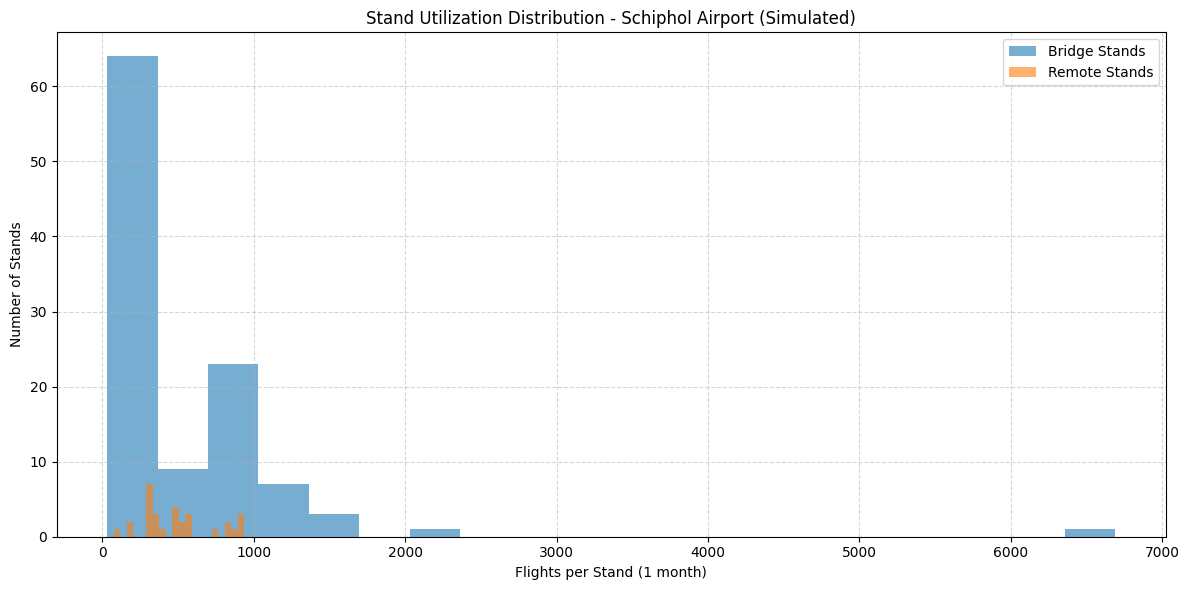

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of flights per stand
stand_counts = df.groupby(['Stand', 'Stand_Type']).size().reset_index(name='Flights')

# Separate bridge stands and remote stands
bridge_counts = stand_counts[stand_counts['Stand_Type'] == 'Bridge']
remote_counts = stand_counts[stand_counts['Stand_Type'] == 'Remote']

# Create histogram plot
plt.figure(figsize=(12, 6))

# Histogram for bridge stands
plt.hist(bridge_counts['Flights'], bins=20, alpha=0.6, label='Bridge Stands')

# Histogram for remote stands
plt.hist(remote_counts['Flights'], bins=20, alpha=0.6, label='Remote Stands')

# Labels and title
plt.xlabel("Flights per Stand (1 month)")
plt.ylabel("Number of Stands")
plt.title("Stand Utilization Distribution - Schiphol Airport (Simulated)")

# Legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()


In [111]:
df.head()

,Flight Number,Status,Scheduled Time,Gate,Stand,Terminal,Scheduled_parsed_utc,Scheduled_parsed_local,Status_simplified,Stand_Type
0,HV5886,"ARR,EXP",2025-07-01T00:00:00.000+02:00,NaN,None,1.0,2025-06-30 22:00:00+00:00,2025-07-01 00:00:00+02:00,ARR,None
1,HV6874,"ARR,EXP",2025-07-01T00:05:00.000+02:00,NaN,None,4.0,2025-06-30 22:05:00+00:00,2025-07-01 00:05:00+02:00,ARR,None
2,KL2558,"ARR,EXP",2025-07-01T00:05:00.000+02:00,NaN,None,4.0,2025-06-30 22:05:00+00:00,2025-07-01 00:05:00+02:00,ARR,None
3,HV6914,ARR,2025-07-01T00:10:00.000+02:00,NaN,None,1.0,2025-06-30 22:10:00+00:00,2025-07-01 00:10:00+02:00,ARR,None
4,KL2612,ARR,2025-07-01T00:10:00.000+02:00,NaN,None,1.0,2025-06-30 22:10:00+00:00,2025-07-01 00:10:00+02:00,ARR,None


# Step 5: check for stand conflicts

In [112]:
import pandas as pd

df_dep = df.copy()

# Only compare flights with the same Stand and Date where the scheduled time difference is less than 40 minutes
# Additional rule: Only compare flights whose Status is exactly "DEP"

# Ensure Scheduled_parsed_local is datetime
df_dep['Scheduled_parsed_local'] = pd.to_datetime(df_dep['Scheduled_parsed_local'], errors='coerce')

# Extract date for same-day comparison
df_dep['local_date'] = df_dep['Scheduled_parsed_local'].dt.date

# Keep only relevant columns for checking
df_dep_check = df_dep[['Stand', 'Gate', 'Flight Number', 'Scheduled_parsed_local', 'local_date', 'Status']].copy()

# Filter: keep only flights whose Status is exactly "DEP"
# If Status column contains multiple codes (e.g., "DEP,DEL"), only keep pure "DEP"
df_dep_check = df_dep_check[df_dep_check['Status'].str.strip() == 'DEP']

# Sort by Stand and Scheduled time
df_dep_check.sort_values(by=['Stand', 'Scheduled_parsed_local'], inplace=True)

# Shift to compare each flight with the next one at the same Stand & Date
df_dep_check['Stand_next'] = df_dep_check['Stand'].shift(-1)
df_dep_check['Date_next'] = df_dep_check['local_date'].shift(-1)
df_dep_check['Flight_next'] = df_dep_check['Flight Number'].shift(-1)
df_dep_check['Gate_next'] = df_dep_check['Gate'].shift(-1)
df_dep_check['Time_next'] = df_dep_check['Scheduled_parsed_local'].shift(-1)
df_dep_check['Status_next'] = df_dep_check['Status'].shift(-1)

# Calculate time difference in minutes
df_dep_check['Diff_minutes'] = (
    df_dep_check['Time_next'] - df_dep_check['Scheduled_parsed_local']
).dt.total_seconds() / 60

# Filter for conflicts: same stand, same day, and time difference < 40 minutes, > 0 minutes
conflicts = df_dep_check[
    (df_dep_check['Stand'] == df_dep_check['Stand_next']) &
    (df_dep_check['local_date'] == df_dep_check['Date_next']) &
    (df_dep_check['Diff_minutes'] > 0) &
    (df_dep_check['Diff_minutes'] < 40)
]

# Select final conflict columns
conflicts = conflicts[[
    'Stand', 'local_date', 'Gate', 'Flight Number', 'Scheduled_parsed_local', 'Status',
    'Gate_next', 'Flight_next', 'Time_next', 'Status_next', 'Diff_minutes'
]]

# Rename columns for readability
conflicts.columns = [
    'Stand', 'Date', 'Gate1', 'Flight1', 'Time1', 'Status1',
    'Gate2', 'Flight2', 'Time2', 'Status2', 'Diff_minutes'
]

print(f"Total potential stand conflicts found (DEP only): {len(conflicts)}")
print(conflicts.head(20))

conflicts.to_csv("stand_conflicts_DEP_only.csv", index=False)

Total potential stand conflicts found (DEP only): 1209
       Stand        Date Gate1 Flight1                     Time1 Status1  \
32534     B1  2025-07-07    B1  MU1815 2025-07-07 20:45:00+02:00     DEP   
65717     B1  2025-07-14    B1  KL3576 2025-07-14 20:45:00+02:00     DEP   
70451     B1  2025-07-15    B1  AF3213 2025-07-15 20:50:00+02:00     DEP   
79932     B1  2025-07-17    B1  MU1815 2025-07-17 20:45:00+02:00     DEP   
84782     B1  2025-07-18    B1  MU1815 2025-07-18 20:45:00+02:00     DEP   
132947    B1  2025-07-28    B1  AF3211 2025-07-28 20:30:00+02:00     DEP   
19834    B18  2025-07-05   B18  SK6750 2025-07-05 09:05:00+02:00     DEP   
24527    B18  2025-07-06   B18  DL9655 2025-07-06 09:25:00+02:00     DEP   
27593    B18  2025-07-06   B18  AF3227 2025-07-06 20:15:00+02:00     DEP   
27765    B18  2025-07-06   B18  SK6832 2025-07-06 20:50:00+02:00     DEP   
37170    B18  2025-07-08   B18  KL1331 2025-07-08 20:35:00+02:00     DEP   
41925    B18  2025-07-09   B18  K

# Step 6: match value in the Stand column for arrival flights

In [113]:
import pandas as pd

# ---------- Configuring column names ----------
flight_col = 'Flight Number'
status_col = 'Status_simplified'
stand_col = 'Stand'
sched_col = 'Scheduled_parsed_local'
gate_col = 'Gate'

# ---------- 1) Snapshot and ensure the time is listed as datetime ----------
df_orig = df.copy()  # Keep the original snapshot for comparison
df_orig[sched_col] = pd.to_datetime(df_orig[sched_col], errors='coerce')

# ---------- 2) Baseline statistics (before matching) ----------
total_arr = df_orig[df_orig[status_col] == 'ARR'].shape[0]
arr_with_stand_before = df_orig[(df_orig[status_col] == 'ARR') & df_orig[stand_col].notna()].shape[0]
arr_without_stand_before = total_arr - arr_with_stand_before

print("== Baseline before matching ==")
print("Total ARR flights:", total_arr)
print("ARR flights with Stand already:", arr_with_stand_before)
print("ARR flights without Stand:", arr_without_stand_before)
print("\nSample ARR flights that already have Stand (head 10):")
print(df_orig[(df_orig[status_col]=='ARR') & df_orig[stand_col].notna()]
      [[flight_col, status_col, gate_col, stand_col, sched_col]].head(10).to_string(index=False))

# ---------- 3) Vectorized matching (same airline & flight number +/- 1 & time sequence & <= 24h) ----------
# For safety reasons, generate Airline & numeric flight number in a temporary table
tmp = df_orig.copy()
tmp['Airline'] = tmp[flight_col].astype(str).str.extract(r'([A-Z]+)', expand=False)
tmp['Flight_num_numeric'] = tmp[flight_col].astype(str).str.extract(r'(\d+)', expand=False).astype(float)

# Only two tables are needed: the ARR (target) of the Stand that needs to be filled, and the DEP (source) of the existing Stand
arr_df = tmp[(tmp[status_col]=='ARR') & tmp[stand_col].isna()].reset_index().rename(columns={'index':'arr_index'})
dep_df = tmp[(tmp[status_col]=='DEP') & tmp[stand_col].notna()].reset_index().rename(columns={'index':'dep_index'})

# If there is no candidate, exit immediately
if arr_df.empty or dep_df.empty:
    print("\nNo arrivals without stands or no departure-with-stand candidates → nothing to fill.")
else:
    # Mark departures with possible matching flight numbers (-1 and +1)
    dep_df['flight_num_minus1'] = dep_df['Flight_num_numeric'] - 1
    dep_df['flight_num_plus1']  = dep_df['Flight_num_numeric'] + 1

    # merge: two cases (arr == dep.minus1 or arr == dep.plus1)
    m1 = arr_df.merge(dep_df,
                      left_on=['Airline','Flight_num_numeric'],
                      right_on=['Airline','flight_num_minus1'],
                      suffixes=('_arr','_dep'),
                      how='inner')
    m2 = arr_df.merge(dep_df,
                      left_on=['Airline','Flight_num_numeric'],
                      right_on=['Airline','flight_num_plus1'],
                      suffixes=('_arr','_dep'),
                      how='inner')

    matches = pd.concat([m1, m2], ignore_index=True, sort=False)

    # If there is no match, the statistics are returned directly
    if matches.empty:
        print("\nNo candidate matches found by ±1 rule.")
    else:
        # Filter: Departure time must be after arrival time and the interval must be less than or equal to 24 hours.
        matches = matches[
            (matches[f'{sched_col}_dep'] > matches[f'{sched_col}_arr']) &
            ((matches[f'{sched_col}_dep'] - matches[f'{sched_col}_arr']) <= pd.Timedelta(hours=24))
        ].copy()

        # If it is still empty, just end it
        if matches.empty:
            print("\nFound candidate pairs but none satisfy time-order / within 24h.")
        else:
            # For each arrival (identified by arr_index ), keep the earliest departure (the one with the earliest scheduled departure).
            matches.sort_values(['arr_index', f'{sched_col}_dep'], inplace=True)
            first_matches = matches.groupby('arr_index', as_index=False).first()

            # Construct mapping: original index arr_index -> dep's Stand value (Stand_dep column)
            # Note: After merging, the Stand column name of departure is stand_col + '_dep'
            stand_dep_col = stand_col + '_dep'
            if stand_dep_col not in first_matches.columns:
                # Adapt to different pandas versions and column naming: try to find a column ending with stand_col
                stand_dep_candidates = [c for c in first_matches.columns if c.endswith('_dep') and c.lower().startswith(stand_col.lower())]
                if stand_dep_candidates:
                    stand_dep_col = stand_dep_candidates[0]
                else:
                    raise KeyError("Cannot find the 'Stand' column for departures in merged result.")

            mapping = dict(zip(first_matches['arr_index'].tolist(), first_matches[stand_dep_col].tolist()))

            # Index list for comparison before and after record filling
            filled_arr_indices = sorted(mapping.keys())

            # Backfill Stand on df_orig (original DataFrame) and mark Stand_filled_flag=True
            df_orig.loc[filled_arr_indices, 'Stand'] = df_orig.loc[filled_arr_indices, 'Stand'].fillna(pd.Series(mapping))
            df_orig.loc[filled_arr_indices, 'Stand_filled_flag'] = True

            # ---------- 4) Post-match statistics ----------
            final_arr_with_stand = df_orig[(df_orig[status_col]=='ARR') & df_orig[stand_col].notna()].shape[0]
            newly_filled = len(filled_arr_indices)
            missing_after = total_arr - final_arr_with_stand

            print("\n== Matching results ==")
            print("Number of ARR stands newly filled in THIS RUN:", newly_filled)
            print("ARR flights with Stand AFTER matching:", final_arr_with_stand)
            print("ARR flights still missing Stand AFTER matching:", missing_after)

            # Show some populated examples（arrival info + the departure we copied from）
            sample_n = 10
            sample_rows = []
            for arr_idx in filled_arr_indices[:sample_n]:
                # row before (we have original df_orig with new Stand now)
                row_arr = df.loc[arr_idx] if arr_idx in df.index else None
                # try to find matched departure row in first_matches
                fm = first_matches[first_matches['arr_index'] == arr_idx]
                if not fm.empty:
                    dep_info = {
                        'dep_index': int(fm['dep_index'].iloc[0]),
                        'dep_flight': fm[flight_col + '_dep'].iloc[0] if flight_col + '_dep' in fm.columns else fm.get(flight_col + '_dep').iloc[0] if flight_col + '_dep' in fm.columns else None,
                        'dep_stand': fm[stand_dep_col].iloc[0],
                        'dep_time': fm[f'{sched_col}_dep'].iloc[0]
                    }
                else:
                    dep_info = {}

                sample_rows.append({
                    'arr_index': arr_idx,
                    'arr_flight': df_orig.at[arr_idx, flight_col],
                    'arr_time': df_orig.at[arr_idx, sched_col],
                    'arr_status': df_orig.at[arr_idx, status_col],
                    'new_stand': df_orig.at[arr_idx, stand_col],
                    'matched_dep_info': dep_info
                })

            print("\nSample of filled ARR flights (first {}):".format(min(sample_n, newly_filled)))
            for r in sample_rows:
                print(r)

            # save the result
            df_orig.to_csv("final_filled_result.csv", index=False)
            first_matches.to_csv("arr_to_dep_matches.csv", index=False)

== Baseline before matching ==
Total ARR flights: 72712
ARR flights with Stand already: 0
ARR flights without Stand: 72712

Sample ARR flights that already have Stand (head 10):
Empty DataFrame
Columns: [Flight Number, Status_simplified, Gate, Stand, Scheduled_parsed_local]
Index: []

== Matching results ==
Number of ARR stands newly filled in THIS RUN: 38916
ARR flights with Stand AFTER matching: 38916
ARR flights still missing Stand AFTER matching: 33796

Sample of filled ARR flights (first 10):
{'arr_index': 0, 'arr_flight': 'HV5886', 'arr_time': Timestamp('2025-07-01 00:00:00+0200', tz='Europe/Amsterdam'), 'arr_status': 'ARR', 'new_stand': 'C9', 'matched_dep_info': {'dep_index': 84, 'dep_flight': 'HV5887', 'dep_stand': 'C9', 'dep_time': Timestamp('2025-07-01 06:30:00+0200', tz='Europe/Amsterdam')}}
{'arr_index': 1, 'arr_flight': 'HV6874', 'arr_time': Timestamp('2025-07-01 00:05:00+0200', tz='Europe/Amsterdam'), 'arr_status': 'ARR', 'new_stand': 'C5', 'matched_dep_info': {'dep_index